#### Multivariate Imputation of Chain Equations 

MICE is a multiple imputation method used to replace missing data values in a data set under certain assumptions about the data missingness mechanism (e.g., the data are missing at random, the data are missing completely at random).

If you start out with a data set which includes missing values in one or more of its variables, you can create multiple copies of this data set - for example, you can create 5 copies of the original data set - and replace the missing data values in each copy using the MICE procedure. You can then:

- Analyze the 5 complete data set copies using your intended statistical analysis;
- Combine (or pool) the results of these complete data analyses;
- Report the combined result.

**MICE steps**

The chained equation process can be broken down into four general steps:

- Step 1: A simple imputation, such as imputing the mean, is performed for every missing value in the dataset. These mean imputations can be thought of as “place holders.”
- Step 2: The “place holder” mean imputations for one variable (“var”) are set back to missing.
- Step 3: The observed values from the variable “var” in Step 2 are regressed on the other variables in the imputation model, which may or may not consist of all of the variables in the dataset. In other words, “var” is the dependent variable in a regression model and all the other variables are independent variables in the regression model. These regression models operate under the same assumptions that one would make when performing linear, logistic, or Poison regression models outside of the context of imputing missing data.
- Step 4: The missing values for “var” are then replaced with predictions (imputations) from the regression model. When “var” is subsequently used as an independent variable in the regression models for other variables, both the observed and these imputed values will be used.
- Step 5: Steps 2–4 are then repeated for each variable that has missing data. The cycling through each of the variables constitutes one iteration or “cycle.” At the end of one cycle all of the missing values have been replaced with predictions from regressions that reflect the relationships observed in the data.
- Step 6: Steps 2–4 are repeated for a number of cycles, with the imputations being updated at each cycle.

[Source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/)


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# load data with numerical variables

variables = ['A2','A3','A8', 'A11', 'A14', 'A15', 'A16']

data = pd.read_csv('../datasets/creditApprovalUci.csv', usecols=variables)

data.head()

,A2,A3,A8,A11,A14,A15,A16
0,30.83,0.000,1.25,1,202.0,0,1
1,58.67,4.460,3.04,6,43.0,560,1
2,24.50,NaN,NaN,0,280.0,824,1
3,27.83,1.540,3.75,5,100.0,3,1
4,20.17,5.625,1.71,0,120.0,0,1


In [3]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

print(f"Train :{X_train.shape}, Test: {X_test.shape}")

Train :(483, 6), Test: (207, 6)


In [4]:
X_train.isnull().mean()

A2     0.022774
A3     0.140787
A8     0.140787
A11    0.000000
A14    0.014493
A15    0.000000
dtype: float64

C:\Users\cssar\miniconda3\envs\whiskey_pt\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


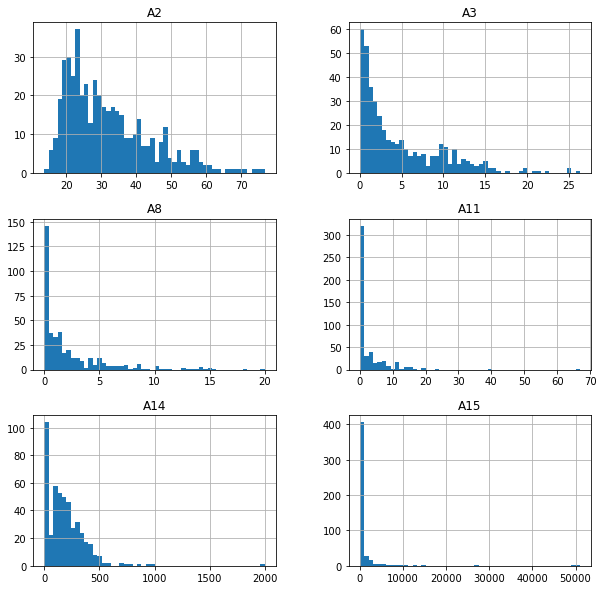

In [5]:
X_train.hist(bins=50, figsize=(10,10))
plt.show()

In [6]:
# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)

In [7]:
# perform MICE

imputer.fit(X_train)

IterativeImputer(estimator=BayesianRidge(), random_state=0, skip_complete=True)

In [8]:
# transform the data - replace the missing values

train_t = imputer.transform(X_train)
test_t = imputer.transform(X_test)

In [11]:
# after the imputation there is no more data missing

pd.DataFrame(train_t, columns=X_train.columns).isnull().sum()

A2     0
A3     0
A8     0
A11    0
A14    0
A15    0
dtype: int64

**Lets compare imputation with different models**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (483, 6), Test: (207, 6)


*Create a multiple MICE imputer*

In [15]:
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=0)

imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(n_neighbors=5),
    max_iter=10,
    random_state=0)

imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(max_features='sqrt', random_state=0),
    max_iter=10,
    random_state=0)

imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
    max_iter=10,
    random_state=0)

In [17]:
imputer_bayes.fit(X_train)
imputer_knn.fit(X_train)
imputer_nonLin.fit(X_train)
imputer_missForest.fit(X_train)

C:\Users\cssar\miniconda3\envs\whiskey_pt\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\cssar\miniconda3\envs\whiskey_pt\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
                 random_state=0)

In [18]:
# replace NA

X_train_bayes = imputer_bayes.transform(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_train_nonLin = imputer_nonLin.transform(X_train)
X_train_missForest = imputer_missForest.transform(X_train)

In [24]:
predictors = [var for var in variables if var !='A16']

In [25]:
# transform numpy array to dataframe
X_train_bayes = pd.DataFrame(X_train_bayes, columns = predictors)
X_train_knn = pd.DataFrame(X_train_knn, columns = predictors)
X_train_nonLin = pd.DataFrame(X_train_nonLin, columns = predictors)
X_train_missForest = pd.DataFrame(X_train_missForest, columns = predictors)

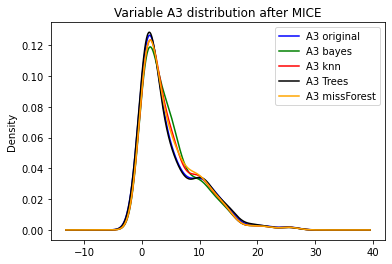

In [26]:
# plot the distribution of the imputed variable

fig = plt.figure()
ax = fig.add_subplot(111)

X_train['A3'].plot(kind='kde', ax=ax, color='blue')
X_train_bayes['A3'].plot(kind='kde', ax=ax, color='green')
X_train_knn['A3'].plot(kind='kde', ax=ax, color='red')
X_train_nonLin['A3'].plot(kind='kde', ax=ax, color='black')
X_train_missForest['A3'].plot(kind='kde', ax=ax, color='orange')

# add legends
lines, labels = ax.get_legend_handles_labels()
labels = ['A3 original', 'A3 bayes', 'A3 knn', 'A3 Trees', 'A3 missForest']
ax.legend(lines, labels, loc='best')
plt.title('Variable A3 distribution after MICE')
plt.show()